## 0. Imports

In [1]:
import utils.dataset_functions as df
import utils.user_features as uf
import utils.two_towers as ttn
import pandas as pd

import torch
from threading import Thread
from pathlib import Path
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm as progress_bar



data_dir = Path("dataset") / "unprocessed"
data_dir.mkdir(parents=True, exist_ok=True)

## 1. Download and write locally to CSV's

In [ ]:
# Write files locally
dataset_types = ["likes", "listens", "dislikes", "unlikes", "undislikes"]
dataset = df.YambdaDataset('flat', '50m')
for dt in dataset_types:
    df.download_df(dataset=dataset, dataset_type=dt)


if not (data_dir / "embeddings.csv").exists():
    embeddings = dataset.audio_embeddings().to_pandas()
    embeddings.to_csv(data_dir / "embeddings.csv", index=False)
    del embeddings

## 2. Load Dataframes

In [ ]:
# User like-dislike interactions
likes = pd.read_csv(data_dir / "likes.csv", usecols=['uid', 'timestamp', 'item_id'])
dislikes = pd.read_csv(data_dir / "dislikes.csv", usecols=['uid', 'timestamp', 'item_id'])
unlikes = pd.read_csv(data_dir / "unlikes.csv", usecols=['uid', 'timestamp', 'item_id'])
undislikes = pd.read_csv(data_dir / "dislikes.csv", usecols=['uid', 'timestamp', 'item_id'])


# If not done before
if (Path("dataset") / "processed" / "merged.csv").exists():
    user_item_data = pd.read_csv(Path("dataset") / "processed" / "merged.csv", index_col=False)
    user_item_data["normalized_embed"] = user_item_data["normalized_embed"].apply(df.parse_embedding)

else:
    # User listen interactions
    listens = pd.read_csv(data_dir / "listens.csv", index_col=False)
    listens.drop(columns=['is_organic'])

    # due to computational limitations, we constrain our dataset to users to have between 500 and 5000 timestamps.
    listens = listens.groupby('uid').filter(lambda x: 500 <= len(x) <= 5000)

    # Embeddings
    embeddings = pd.read_csv(data_dir/'embeddings.csv', usecols=['item_id', 'normalized_embed'])
    embeddings["normalized_embed"] = embeddings["normalized_embed"].apply(df.parse_embedding)

    # Merge the song embeddings and user listens dataset 
    user_item_data = pd.merge(listens, embeddings, on='item_id', how='inner')
    
    user_id_index = {}
    for index, user in enumerate(user_item_data['uid'].unique()):
        user_id_index[user] = index
    user_item_data['uid'] = user_item_data['uid'].map(user_id_index)
    user_item_data.to_csv(Path("Dataset") / "processed" / "merged.csv")

    # save memory
    del listens
    del embeddings


user_item_data

## 3. Create and save user features
We do this in train/val/test splits

In [ ]:
users = user_item_data['uid'].unique()

__train_val_set, test_set = train_test_split(
    users,
    test_size=0.10,   # 10 % is test data
    random_state=42,        # reproducible shuffling
    shuffle=True
)

train_set, val_set = train_test_split(
    __train_val_set,
    test_size=0.22,   # ~20% validation
    random_state=42,
    shuffle=True
)


print("train:", len(train_set), "users")
print("val  :", len(val_set), "users")
print("test :", len(test_set), "users")

# poorly designed split, but I'm okay with losing a few users (we have more than enough anyway).
# Added + 1 in the indices to ensure no duplicates (still horrible method though).
train_split = len(train_set)//4 

# Multithread it to make it somewhat time managable
t1 = Thread(target=uf.extract_and_save_features, args=(train_set[0:train_split], user_item_data, likes, unlikes, dislikes, undislikes, 'train'))
t2 = Thread(target=uf.extract_and_save_features, args=(train_set[train_split+1:2*train_split], user_item_data, likes, unlikes, dislikes, undislikes, 'train'))
t3 = Thread(target=uf.extract_and_save_features, args=(train_set[2*train_split+1:3*train_split], user_item_data, likes, unlikes, dislikes, undislikes, 'train'))
t4 = Thread(target=uf.extract_and_save_features, args=(train_set[3*train_split+1:4*train_split], user_item_data, likes, unlikes, dislikes, undislikes, 'train'))
t5 = Thread(target=uf.extract_and_save_features, args=(val_set, user_item_data, likes, unlikes, dislikes, undislikes, 'val'))
t6 = Thread(target=uf.extract_and_save_features, args=(test_set, user_item_data, likes, unlikes, dislikes, undislikes, 'test'))

t1.start()
t2.start()
t3.start()
t4.start()
t5.start()
t6.start()


t1.join()
t2.join()
t3.join()
t4.join()
t5.join()
t6.join()

In [ ]:
# free up memory, we don't need this anymore
del user_item_data 
del likes
del unlikes
del dislikes
del undislikes

### 3.1: merge the seperate user files

In [ ]:
for data_type in ['train', 'val', 'test']:
    files = Path("dataset") / "processed" / data_type
    user_feats = []
    user_ids = []
    song_embeds = []
    labels = []

    for file in progress_bar(list(files.glob("*.pt")), desc=f"loading and merging {data_type} files"):
        loaded = torch.load(file, map_location="cpu")
        user_feats.append(loaded["user_feats"])
        user_ids.append(loaded["user_ids"])
        song_embeds.append(loaded["song_embeds"])
        labels.append(loaded["labels"])

        del loaded
    
    user_feats   = torch.cat(user_feats, dim=0)
    user_ids     = torch.cat(user_ids, dim=0)
    song_embeds  = torch.cat(song_embeds, dim=0)
    labels       = torch.cat(labels, dim=0)

    uf.save_tensor_dataset(file_name=data_type, user_feats=user_feats, user_ids=user_ids, song_embeds=song_embeds, labels=labels, file_loc=Path("dataset"))  

## 4. Training the model

### 4.1 set the parameters

In [4]:
data_dir = Path("dataset") / "unprocessed"
data_dir.mkdir(parents=True, exist_ok=True)

data_dir = Path("dataset") / "unprocessed"
data_dir.mkdir(parents=True, exist_ok=True)

# Input dimensions
user_dim        = 6
item_dim        = 128
aug_dim         = 32

# Dimensions of the tower FFN
hidden_dim      = 64
embed_dim       = 32

# lambda1 for loss_u & lambda2 for loss_V
lambda1         = 1
lambda2         = 1

# Training
num_epochs      = 5
learning_rate   = 0.001
batch_size      = 32

# With rf_signal we determine on what predetermined label (reinforcement signal) we want to train on.
# Note: This should be an int between the values 0 and 3.
# Cheat sheet: [interactions_label, multiple_listens_label, pct_100_label, pct_80_label]
label_id = 0

### 4.2 Training our models

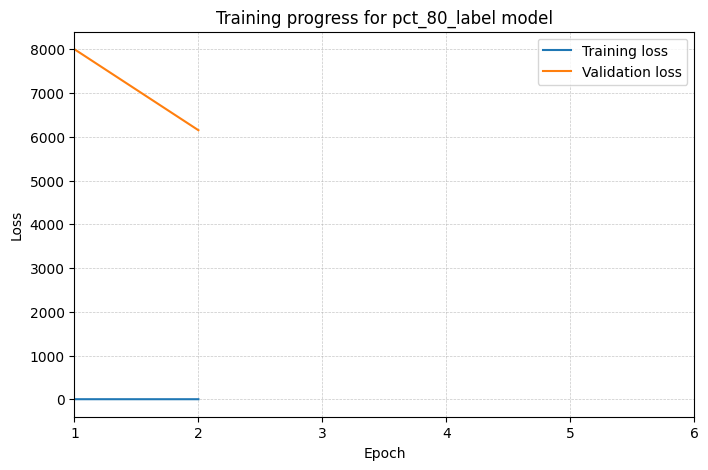

In [ ]:
models = ["interactions_model", "multiple_listens_model", "pct_100_model", "pct_80_model"]

for label_id, model_name in enumerate(models):
    train_set = df.load_tensor_dataloader("train", Path("dataset"), batch_size, label_id)
    val_set = df.load_tensor_dataloader("val", Path("dataset"), batch_size, label_id)
    test_set = df.load_tensor_dataloader("test", Path("dataset"), batch_size, label_id)

    model = ttn.DualAugmentedTwoTower(model_name, user_dim, item_dim, aug_dim, hidden_dim, embed_dim)
    optimiser = torch.optim.Adam(model.parameters(), lr = learning_rate)
    ttn.train_model(model, train_set, val_set, optimiser, num_epochs=num_epochs, device='cuda' if torch.cuda.is_available() else 'cpu')